<a href="https://colab.research.google.com/github/brunopjacob/ml_examples/blob/master/ml_examples/blob/master/02_Keras_Cats_vs_Dogs/cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Dogs vs cats example with convolutional neural network (CNN) classifier**



In [2]:
# Import packages

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.image as mpimg
from skimage.transform import resize


**Load and preprocess the data**

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete06Y7G2/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
(262, 350, 3) tf.Tensor(1, shape=(), dtype=int64)
(500, 377, 3) tf.Tensor(0, shape=(), dtype=int64)


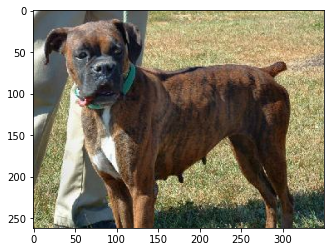

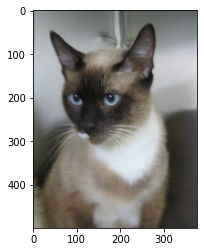

In [3]:
# Load cats vs dogs dataset

ds_train = tfds.load('cats_vs_dogs', as_supervised=True, split='train[:90%]')   # first 90% of the dataset
ds_test = tfds.load('cats_vs_dogs', as_supervised=True, split='train[-10%:]')  # last 10% of the dataset

# Copy dataset ds_train to augment it
ds_train_augmented = tfds.load('cats_vs_dogs', as_supervised=True, split='train[:90%]')

for image, label in ds_train.take(1):
  plt.figure(1)
  plt.imshow(image)
  my_test_image_dog = image
  print(image.shape, label)

for image, label in ds_test.take(1):
  plt.figure(2)
  plt.imshow(image)
  my_test_image_cat = image
  my_test_image_cat_label = label.numpy()
  print(image.shape, label)



In [4]:
##### Mapping step:

# Normalize images
def normalize(image, label):
#  """Normalizes images: uint8 -> float32."""
  return tf.cast(image, tf.float32) / 255. , label

# Resize images
def reduce(image, label):
  return tf.image.resize(image,[200,200]), label

# Flip images (data augmentation)
def flip(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

# Change image colors (data augmentation)
def color(image, label) -> tf.Tensor:
    image = tf.image.random_hue(image, 0.08)
    image = tf.image.random_saturation(image, 0.6, 1.6)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.7, 1.3)
    return image, label

# Rotate images (data augmentation)
def rotate(image, label):
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)), label

# Clip images (data augmentation)
def clip(image, label):
  # Make sure that the values are still in [0, 1]
  return tf.clip_by_value(image, 0, 1), label 

# Def parallel autocalls
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Preprocessing functions for each dataset
config_train_augmented = [reduce, flip, rotate, normalize, clip]
config_train = [reduce, normalize]
config_test = [reduce, normalize, clip]


# Add the augmentations to the train dataset
for f in config_train_augmented:
    # Apply the augmentation
    ds_train_augmented = ds_train_augmented.map(f, num_parallel_calls=AUTOTUNE)

for f in config_train:
    # Apply the augmentation
    ds_train = ds_train.map(f, num_parallel_calls=AUTOTUNE)

# Add the augmentations to the test dataset
for f in config_test:
    # Apply the augmentation
    ds_test = ds_test.map(f, num_parallel_calls=AUTOTUNE)

# Append ds_train_augmented and ds_train for data augmentation
ds_train = ds_train.concatenate(ds_train_augmented)


(200, 200, 3) tf.Tensor(1, shape=(), dtype=int64)


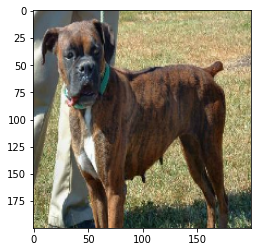

In [5]:
# Check reduced images
for image, label in ds_train.take(1):
  plt.figure(3)
  plt.imshow(image)
  print(image.shape, label)

In [6]:
# Batch all datasets
batch_size = 400
ds_train = ds_train.batch(batch_size)
ds_test = ds_test.batch(batch_size)

# Cache
#ds_train = ds_train.cache()
#ds_test = ds_test.cache()

# Prefetch
ds_train.prefetch(buffer_size=AUTOTUNE)
ds_test.prefetch(buffer_size=AUTOTUNE)


<PrefetchDataset shapes: ((None, 200, 200, 3), (None,)), types: (tf.float32, tf.int64)>

**Build the convolutional neural network (CNN) model**

This CNN has the following specifications

*   A 2D convolutional layer with a 3x3 kernel and 16 filters, "same" padding and ReLU activation functions.
*   A 2D max pooling layer, with a 2x2 window, and default strides.
*   A 2D convolutional layer with a 3x3 kernel and 32 filters, "same" padding and ReLU activation functions.
*   A 2D max pooling layer, with a 2x2 window, and default strides.
*   A 2D convolutional layer with a 3x3 kernel and 64 filters, "same" padding and ReLU activation functions.
*   A 2D max pooling layer, with a 2x2 window, and default strides.
*   A flatten layer, which unrolls the input into a one-dimensional tensor.
*   Two dense hidden layer, with 64 units each and ReLU activation functions.
*   A dropout layer with dropout rate 0.5
*   A dense output layer with 2 units and the softmax activation function.




In [13]:
# Create the model and display summary

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 100x100 with 3 color channels
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(200,200,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # Hidden layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # Final layer (classifier)
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)            

In [14]:
# Compile model function
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


**Fit the model to the training data**

In [15]:
# Train the model on the dataset, using the model's fit method.

history = model.fit(ds_train, batch_size = 400, shuffle=True, epochs=20, validation_data=ds_test)

Epoch 1/20
105/105 [==============================] - 88s 840ms/step - loss: 0.7009 - accuracy: 0.5157 - val_loss: 0.6810 - val_accuracy: 0.5744
Epoch 2/20
105/105 [==============================] - 89s 845ms/step - loss: 0.6422 - accuracy: 0.6234 - val_loss: 0.5809 - val_accuracy: 0.6892
Epoch 3/20
105/105 [==============================] - 90s 854ms/step - loss: 0.5944 - accuracy: 0.6968 - val_loss: 0.5392 - val_accuracy: 0.7296
Epoch 4/20
105/105 [==============================] - 90s 856ms/step - loss: 0.5661 - accuracy: 0.7201 - val_loss: 0.5148 - val_accuracy: 0.7618
Epoch 5/20
105/105 [==============================] - 90s 860ms/step - loss: 0.5410 - accuracy: 0.7394 - val_loss: 0.4917 - val_accuracy: 0.7721
Epoch 6/20
105/105 [==============================] - 90s 861ms/step - loss: 0.5214 - accuracy: 0.7550 - val_loss: 0.4922 - val_accuracy: 0.7842
Epoch 7/20
105/105 [==============================] - 90s 861ms/step - loss: 0.4988 - accuracy: 0.7714 - val_loss: 0.4707 - val_ac

**Plot the learning curves**

We will now plot two graphs:

*   Epoch vs accuracy
*   Epoch vs loss

We load the model history into a pandas DataFrame and use the plot method to output the required graphs.




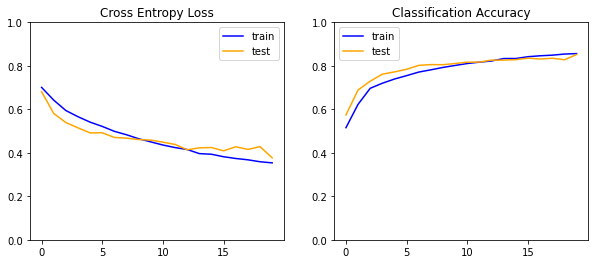

In [16]:
# plot loss
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].set_title('Cross Entropy Loss')
ax[0].plot(history.history['loss'], color='blue', label='train')
ax[0].plot(history.history['val_loss'], color='orange', label='test')
ax[0].set_ylim([0, 1])
ax[0].legend()

# plot accuracy
ax[1].set_title('Classification Accuracy')
ax[1].plot(history.history['accuracy'], color='blue', label='train')
ax[1].plot(history.history['val_accuracy'], color='orange', label='test')
ax[1].set_ylim([0, 1])
ax[1].legend()


# save plot to file
#filename = sys.argv[0].split('/')[-1]
#pyplot.savefig(filename + '_plot.png')
#pyplot.close()


**Model predictions**

Let's test our model with of our own images, and display the predicted label for each.


[[0.7407085  0.25929153]] [0.7407085  0.25929153] 0
[[0.6352423  0.36475778]] [0.6352423  0.36475778] 0
[[0.66299635 0.33700362]] [0.66299635 0.33700362] 0


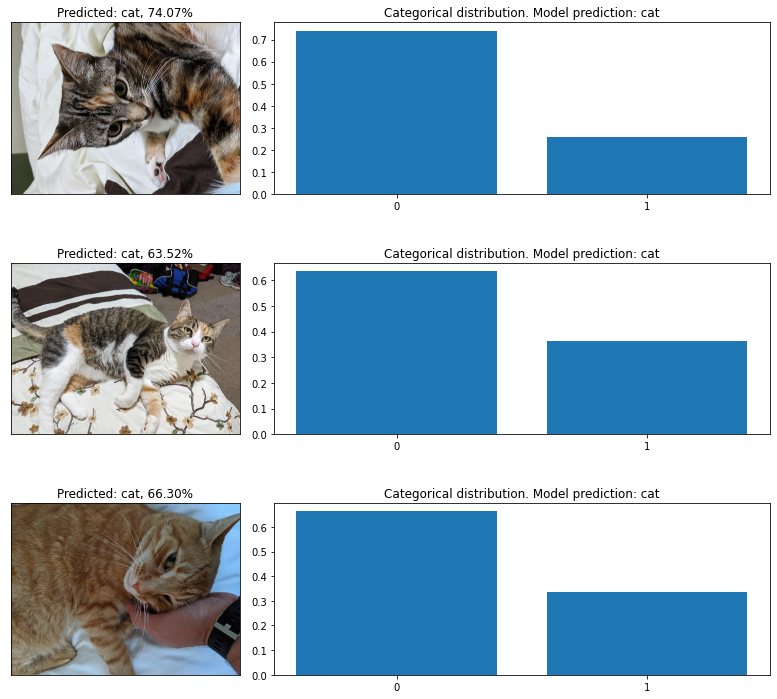

In [17]:
# Load specific image

dir_name = ("./drive/My Drive/Colab Notebooks/cats_vs_dogs/my_cats_images/")
image_names = ["chloe_photo", "kate_photo", "leo_photo"]
extension = ".jpg"

# Recall: cat => label 0, dog => label 1
labels = ['cat','dog']

# Crete fig and axis for 3 images
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, im_name in enumerate(image_names):

  # Read images
  filename = dir_name + im_name + extension
  image = mpimg.imread(filename)

  # Convert image to numpy array and reshape it
  im_data = np.asarray(image)
  #if im_name == image_names[0]: # Rotate Chloe's photo
  #  im_data = im_data.transpose(1,0,2)
  im_data = resize(im_data,(200,200))
  im_data = im_data[np.newaxis,...]

  # Convert to tensor
  #im_tensor = tf.convert_to_tensor(im_data, dtype=tf.float32)
  #im_tensor = tf.expand_dims(im_tensor, axis=0)

  #prediction_array = probability_model(im_tensor)
  #print(prediction_array)
  
  
  predictions_array = model.predict(im_data)
  predictions = np.concatenate(predictions_array)
  predicted_label = np.argmax(predictions_array) 
  print(predictions_array,predictions,predicted_label)
  #plt.figure()
  #plt.imshow(image)
  #plt.title("Predicted: {}".format(labels[predicted_label]));

  axes[i, 0].imshow(np.squeeze(image))
  axes[i, 0].get_xaxis().set_visible(False)
  axes[i, 0].get_yaxis().set_visible(False)
  axes[i, 0].set_title("Predicted: {:s}, {:0.2f}%".format(labels[predicted_label],np.max(predictions)*100))
  axes[i, 1].bar(np.arange(len(predictions)), predictions)
  axes[i, 1].set_xticks(np.arange(len(predictions)))
  axes[i, 1].set_title("Categorical distribution. Model prediction: {}".format(labels[predicted_label]))

